## 0. Wstęp i inicjalizacja projektu

### 0.1 Wstęp

Celem laboratorium jest dokonanie licznych eksperymentów dla drzew decyzyjnych w oparciu o współczynnik Giniego.

Zostaną przeprowadzone liczne eksperymenty testujące wpływ odpowiednich hiperparametrów na zdolności algorymu.

Użytymi zbiorami danych będą Wine oraz Polish Bankruptcy Companies.

Wyniki będą analizowane na podstawie wizualizacji drzew, accuracy, recall, precision oraz F1 score.


### 0.2 Inicjalizacja projektu

Do przeprowadzenia projektu konieczne są biblioteki:
1. ucimlrepo - pobranie zbioru danych
2. pandas - analiza tabelaryczna danych
3. numpy - operacje na macierzach
4. matplotlib/seaborn - wizualizacja analizy danych w formie wykresów
5. sklearn - zbiory danych oraz klasyfikator KNN

In [295]:
from ucimlrepo import fetch_ucirepo 
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
from sklearn.impute import SimpleImputer
from IPython.display import display
from sklearn.preprocessing import StandardScaler

## 1. Zaczytanie zbiorów danych WINE oraz Polish Companies Bankruptcy.

In [47]:
wine = load_wine(as_frame=True)
X_wine = wine.data
y_wine = wine.target

In [3]:
polish_companies_bankruptcy = fetch_ucirepo(id=365)
X_pcb = polish_companies_bankruptcy.data.features
y_pcb = polish_companies_bankruptcy.data.targets

## 2. Uruchomienie algorytmu drzewa decyzyjnego dla WINE dla domyślnych parametrów.

Utworzono klasyfikator dla domyślnych parametrów, czyli:
- `criterion='gini'` - współczynnik podziału
- `splitter='best'` – wybierany najlepszy podział
- `max_depth=None` – brak ograniczenia głębokości drzewa
- `min_samples_split=2` – minimalna liczba próbek potrzebna do podziału węzła
- `min_samples_leaf=1` – minimalna liczba próbek w liściu
- `min_weight_fraction_leaf=0.0` – minimalna waga próbek w liściu (dla danych z wagami)
- `max_features=None` – używane wszystkie cechy przy szukaniu podziału
- `max_leaf_nodes=None` – brak limitu liczby liści
- `min_impurity_decrease=0.0` – minimalny spadek nieczystości wymagany do podziału
- `class_weight=None` – klasy traktowane równoważnie (brak wag klas)
- `ccp_alpha=0.0` – brak prooningu

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

In [240]:
cm = confusion_matrix(y_test, y_hat)
report = classification_report(y_test, y_hat, target_names=wine.target_names, output_dict=True)
labels = wine.target_names

## 3. Wizualizacja drzewa i analiza jakości klasyfikacji wynikowego drzewa decyzyjnego

### 3.1 Wizualizacja drzewa

Poniższe drzewo zostało zbudowane przy użyciu domyślnych hiperparametrów. Klasyfikator dzieli dane na podstawie współczynnika Giniego, wybierając w każdym węźle cechę maksymalizującą czystość podziału.

#### Analiza informacji w liściach
- `atribute` - atrybut na samej górze jest decyzujący i podsiada warunek według którego tworzy podział na kolejne gałęzie/liście
- `samples` – liczba próbek trafiających do danego liścia.
- `value = [class_0, class_1, class_2]` – liczba próbek w liściu dla klas 0, 1, 2.
- `class = class_n` – dominująca klasa przypisana przez model.
- `gini` - powiadamia nas jak "czysty" jest aktualny stan podziału. Przy waartości 0 posiadamy sample jedynie jednej klasy.

## Główne obserwacje

### Korzeń drzewa:
- Pierwszy podział oparty jest na zmiennej `color_intensity`:
  - Jeśli `color_intensity ≤ 3.825`, próbki trafiają do lewej gałęzi,
  - W przeciwnym wypadku do prawej gałęzi.

#### Lewa gałąź (`color_intensity ≤ 3.825`):
- Podział następuje według zmiennej `ash ≤ 3.07`:
    - Lewa gałąź:
        - `alcohol ≤ 13.69`:
        - 46 próbek zaklasyfikowano jako `class_1` (gini = 0.0),
        - 1 próbka zaklasyfikowana jako `class_0` (gini = 0.0),
    - Druga odnoga zawiera tylko 1 próbkę `class_0` (gini = 0.0).

#### Prawa gałąź (`color_intensity > 3.825`):
- Pierwszy podział oparty na `flavanoids ≤ 1.58`:
  - Lewa gałąź (`ash ≤ 2.06`):
    - Dalszy podział tworzy liść z 44 próbkami `class_2` i 1 `class_1`.
  - Prawa gałąź (`proline ≤ 679.0`):
    - Dalszy podział tworzy liść z 9 próbek `class_1` oraz liśc z 40 próbek `class_0`.

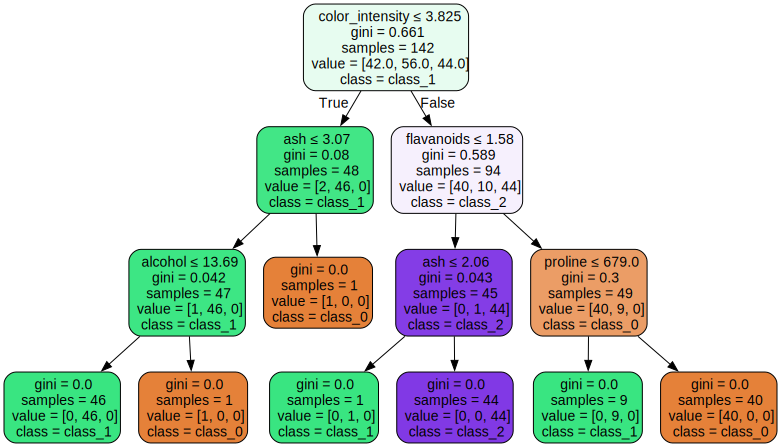

In [ ]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X_wine.columns,
    class_names=labels,
    filled=True,
    rounded=True,
    special_characters=True
)

graphviz.Source(dot_data)

### 3.2 Analiza jakości klasyfikacji

Klasyfikator poradził sobie bardzo dobrze na danych testowych. Znaczna większość danych została prawidłowo sklasyfikowana dając nam 94,4% accuracy.

- Dla klasy `class_0` jedynie pomylono jedno wino z class_1
- Dla najbardziej reprezentowanej klasy `class_1` sklasyfikowano prawidłowo 12 przypadków.
- Dla `class_2` prawidłowo sklafyskowano 10 win, lecz dla jednego przypadku klasyfikator sie pomylił twierdząc, iż jest to wino z class_1

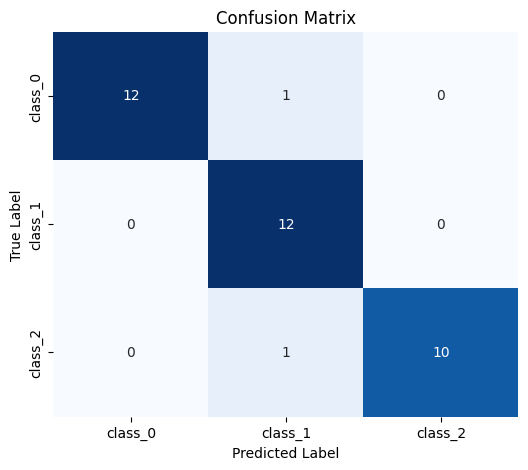

In [284]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Analiza wyników Precision, Recall oraz F1 dla poszczególnych klas ukazuje, iż klasyfikator poradził sobie bardzo dobrze dla domyślnych parametrów.

- klasa `class_0` posiada precision na poziomie 100% ze względu na brak pomyłek sklasyfikowania innej klasy jako `class_0` oraz jeden błąd przez co recall wynosi 92%

- klasa `class_1` posiadamy bezbłędny recall, jako iż skasyfikowano każdy przypadek class-2 prawidłowo, lecz pozostałe klasy twierdziły, iż są class_1

- Klasa `class_2` posiada precision na poziomie 100% ze względu na brak pomyłek sklasyfikowania  innej klasy jako `class_2`oraz jeden błąd przez co recall wynosi 91% (mniej niż w `class_0`, ponieważ mamy mniej próbek)

accuracy: 0.9444444444444444


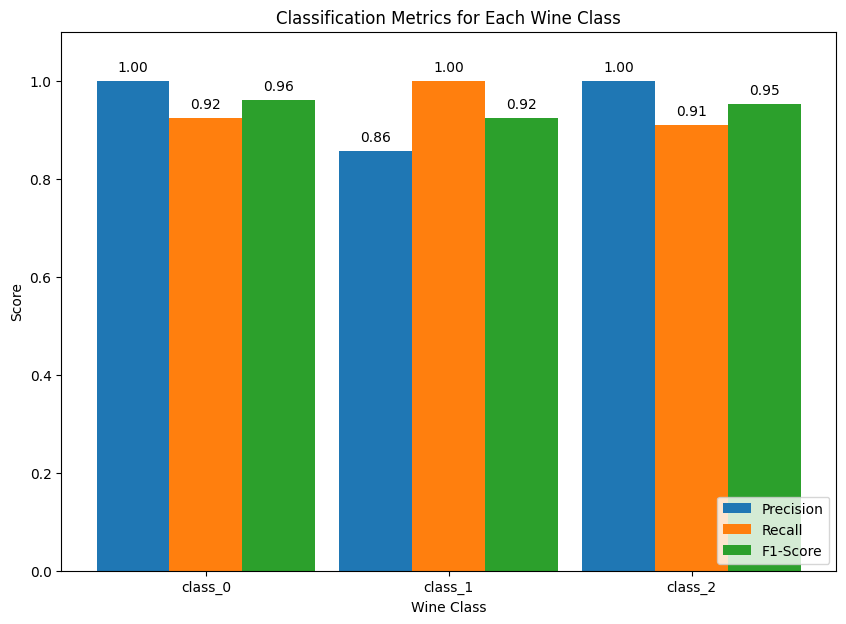

In [285]:
print(f'accuracy: {report["accuracy"]}')

precision = [report[l]["precision"] for l in labels]
recall = [report[l]["recall"] for l in labels]
f1_score = [report[l]["f1-score"] for l in labels]

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(10, 7))

plt.bar(x - width, precision, width, label="Precision")
plt.bar(x, recall, width, label="Recall")
plt.bar(x + width, f1_score, width, label="F1-Score")

plt.title(f"Classification Metrics for Each Wine Class")
plt.xlabel(f"Wine Class")
plt.xticks(ticks=x, labels=labels)
plt.ylabel("Score")
plt.ylim(0, 1.1)

for i in range(len(labels)):
    plt.text(x[i] - width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=10)
    plt.text(x[i], recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=10)
    plt.text(x[i] + width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center', fontsize=10)


plt.legend(loc='lower right')
plt.show()

## 4. Wstępne strojenie algorytmów dla zbiorów

- `max_depth`: maksymalna głębokość drzewa – ogranicza złożoność modelu.
- `min_samples_leaf`: minimalna liczba próbek w liściu – zapobiega przeuczeniu.
- `ccp_alpha`: parametr przycinania drzewa – im wyższy, tym mocniejsze przycinanie.

Poniższa funkcja umożliwia zbadanie `macro_avg` dla  `precision`, `recall` oraz `F1 score`.

Przed treningiem dokonuje minimalistycznego preprocesingu w formie skalowania danych.

Zwracany jest tytuł, klasyfikator oraz `macro_avg` metryk, które posłużą w dalszej analizie

In [466]:
def train_and_evaluate(X_train, X_test, y_train, y_test, params, title, target_names):
    clf = DecisionTreeClassifier(**params)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return title, clf, classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)['macro avg']

### 4.1 WINE

Zdefiniowano ciekawe konfiguracje dla zbioru wine, tak aby zapewnić dyweersyfikację wśród danych, jednocześnie móc sprawdzić wpływ ccp_alpha na wyniki eksperymentów.

In [467]:
wine_configs = [
    {"max_depth": 3, "min_samples_leaf": 2, "ccp_alpha": 0.01},
    {"max_depth": 5, "min_samples_leaf": 3, "ccp_alpha": 0.0},
    {"max_depth": 5, "min_samples_leaf": 3, "ccp_alpha": 0.0},
    {"max_depth": 5, "min_samples_leaf": 3, "ccp_alpha": 0.001},
    {"max_depth": 5, "min_samples_leaf": 3, "ccp_alpha": 0.005},
    {"max_depth": 5, "min_samples_leaf": 3, "ccp_alpha": 0.01},
    {"max_depth": 6, "min_samples_leaf": 2, "ccp_alpha": 0.002},
    {"max_depth": 3, "min_samples_leaf": 1, "ccp_alpha": 0.02},
    {"max_depth": 2, "min_samples_leaf": 5, "ccp_alpha": 0.0},
    {"max_depth": 2, "min_samples_leaf": 5, "ccp_alpha": 0.02},
    {"max_depth": None, "min_samples_leaf": 5, "ccp_alpha": 0.1},
    {"max_depth": None, "min_samples_leaf": 5, "ccp_alpha": 0.05},
]

wine_titles = [
    f"depth={'None' if cfg['max_depth'] is None else cfg['max_depth']}, leaf={cfg['min_samples_leaf']}, a={cfg['ccp_alpha']}"
    for cfg in wine_configs
]

Dokonano `train_test_split` niestratyfikując zbioru oraz nie używając cross validacji. (jest to część kolejnego zadania)

In [468]:
wine_results = dict()
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2)

for config, title in zip(wine_configs, wine_titles):
    title, clf, macros = train_and_evaluate(X_train, X_test, y_train, y_test, config, title, wine.target_names)
    wine_results[title] = macros, clf

Jako wstępne sprawdzenie poprawności uczenia, dokonuje się krótkiego wypisania wyników eksperymentów.

In [469]:
for title, data in wine_results.items():
    scores = data[0]
    print(f"{title}: F1 = {scores['f1-score']:.3f}, Precision = {scores['precision']:.3f}, Recall = {scores['recall']:.3f}")

depth=3, leaf=2, a=0.01: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=5, leaf=3, a=0.0: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=5, leaf=3, a=0.001: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=5, leaf=3, a=0.005: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=5, leaf=3, a=0.01: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=6, leaf=2, a=0.002: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=3, leaf=1, a=0.02: F1 = 0.908, Precision = 0.917, Recall = 0.922
depth=2, leaf=5, a=0.0: F1 = 0.883, Precision = 0.881, Recall = 0.886
depth=2, leaf=5, a=0.02: F1 = 0.883, Precision = 0.881, Recall = 0.886
depth=None, leaf=5, a=0.1: F1 = 0.883, Precision = 0.881, Recall = 0.886
depth=None, leaf=5, a=0.05: F1 = 0.908, Precision = 0.917, Recall = 0.922


### 4.2 PCB

Podobnie zdefiniowano oddzielny zestaw konfiguracji hiperparametrów, tym razem zwarając uwagę na znacznie większy rozmiar datasetu wzlędem rekordów oraz atrybutów.

In [470]:
pcb_configs = [
    {"max_depth": 8, "min_samples_leaf": 4, "ccp_alpha": 0.005},
    {"max_depth": 10, "min_samples_leaf": 3, "ccp_alpha": 0.001},
    {"max_depth": 10, "min_samples_leaf": 3, "ccp_alpha": 0.002},
    {"max_depth": 10, "min_samples_leaf": 3, "ccp_alpha": 0.004},
    {"max_depth": 10, "min_samples_leaf": 5, "ccp_alpha": 0.001},
    {"max_depth": 10, "min_samples_leaf": 6, "ccp_alpha": 0.001},
    {"max_depth": 15, "min_samples_leaf": 5, "ccp_alpha": 0.005},
    {"max_depth": 20, "min_samples_leaf": 5, "ccp_alpha": 0.007},    
    {"max_depth": 25, "min_samples_leaf": 5, "ccp_alpha": 0.001},
    {"max_depth": None, "min_samples_leaf": 3, "ccp_alpha": 0.001},
    {"max_depth": 10, "min_samples_leaf": 3, "ccp_alpha": 0.1}, 
]

pcb_titles = [
    f"depth={'None' if cfg['max_depth'] is None else cfg['max_depth']}, leaf={cfg['min_samples_leaf']}, a={cfg['ccp_alpha']}"
    for cfg in pcb_configs
]

In [563]:
pcb_results = dict()
X_train, X_test, y_train, y_test = train_test_split(X_pcb, y_pcb, test_size=0.15, stratify=y_pcb)

for config, title in zip(pcb_configs, pcb_titles):
    title, clf, macros = train_and_evaluate(X_train, X_test, y_train, y_test, config, title, ["no bankruptcy", "bankruptcy"])
    pcb_results[title] = macros, clf

In [472]:
for title, data in pcb_results.items():
    scores = data[0]
    print(f"{title}: F1 = {scores['f1-score']:.3f}, Precision = {scores['precision']:.3f}, Recall = {scores['recall']:.3f}")

depth=8, leaf=4, a=0.005: F1 = 0.695, Precision = 0.973, Recall = 0.629
depth=10, leaf=3, a=0.001: F1 = 0.745, Precision = 0.964, Recall = 0.672
depth=10, leaf=3, a=0.002: F1 = 0.695, Precision = 0.973, Recall = 0.629
depth=10, leaf=3, a=0.004: F1 = 0.695, Precision = 0.973, Recall = 0.629
depth=10, leaf=5, a=0.001: F1 = 0.745, Precision = 0.964, Recall = 0.672
depth=10, leaf=6, a=0.001: F1 = 0.745, Precision = 0.964, Recall = 0.672
depth=15, leaf=5, a=0.005: F1 = 0.695, Precision = 0.973, Recall = 0.629
depth=20, leaf=5, a=0.007: F1 = 0.488, Precision = 0.476, Recall = 0.500
depth=25, leaf=5, a=0.001: F1 = 0.745, Precision = 0.964, Recall = 0.672
depth=None, leaf=3, a=0.001: F1 = 0.745, Precision = 0.964, Recall = 0.672
depth=10, leaf=3, a=0.1: F1 = 0.488, Precision = 0.476, Recall = 0.500


## 5. Wizualizacja drzew dla różnych hiperparametrów i analiza jakości klasyfikacji wynikowych drzew decyzyjnych

Funkcja `plot_results` tworzy barplot dla każdej z `macro_avg` metryk dla każdego z eksperymentów.

In [ ]:
def plot_results(results_dict, title, min_value=0.6):
    data = []
    for config_title, (metrics, _) in results_dict.items():
        data.append({
            "Config": config_title,
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1-score": metrics["f1-score"]
        })

    df = pd.DataFrame(data)
    df_melted = df.melt(id_vars="Config", var_name="Metric", value_name="Value")

    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_melted, x="Config", y="Value", hue="Metric")

    plt.title(title)
    plt.ylabel("Wartość metryki")
    plt.xlabel("Konfiguracja")
    plt.xticks(rotation=45)
    plt.ylim(min_value, 1.0)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Funckja `plot_trees` wyszukuje 3 przykładowe drzewa (dla najlepszego, najgorszego oraz "statystycznego" wyniku `macro-f1-score`), a następnie je plotuje

In [474]:
def plot_trees(results, feature_names, class_names):
    f1s = [data[0]["f1-score"] for data in results.values()]
    f1s_sorted = sorted(f1s)
    
    f1_max = max(f1s)
    f1_min = min(f1s)
    f1_median = np.median(f1s_sorted)

    interesting_trees = {}
    found_trees = []
    for title, data in results.items():
        f1 = data[0]["f1-score"]
        if np.isclose(f1, f1_max) and "max" not in found_trees:
            interesting_trees[f'{title} (max f1={f1:.4f})'] = data[1]
            found_trees.append("max")
        elif np.isclose(f1, f1_min) and "min" not in found_trees:
            interesting_trees[f'{title} (min f1={f1:.4f})'] = data[1]
            found_trees.append("min")
        elif np.isclose(f1, f1_median) and "median" not in found_trees:
            interesting_trees[f'{title} (median f1={f1:.4f})'] = data[1]
            found_trees.append("median")

        if len(interesting_trees) == 3:
            break

    for title, tree in interesting_trees.items():
        print(f"Tree for {title}")
        dot_data = export_graphviz(
            tree,
            out_file=None,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            rounded=True,
            special_characters=True
        )
        graph = graphviz.Source(dot_data)
        display(graph)

### 5.1 WINE

- Wyniki dla wszystkich metryk są bardzo wysokie i stabilne — większość konfiguracji osiąga wartości powyżej 90%.
- Niewielkie różnice widoczne są dla najbardziej restrykcyjnych konfiguracji (np. `depth=2`, `leaf=5`, `a=0.0` oraz `depth=None, leaf=5, a=0.1`), gdzie metryki osiągają gorsze wyniki.
- `Precision`, `Recall` oraz `F1-score` są zbliżone dla każdej konfiguracji, co wskazuje na dobrze zbalansowany model przy tej wielkości zbioru i braku istotnych problemów z dysproporcją klas.
- Zastosowanie bardziej złożonych drzew (większe `max_depth`, mniejsze `ccp_alpha`) nie prowadzi do zauważalnego wzrostu jakości predykcji, co sugeruje że dla tego zbioru prostsze modele są wystarczające.

Drzewo decyzyjne dobrze radzi sobie na zbiorze WINE przy większości konfiguracji. Nie ma wyraźnej potrzeby stosowania bardzo głębokich drzew ani niskich wartości `ccp_alpha`.

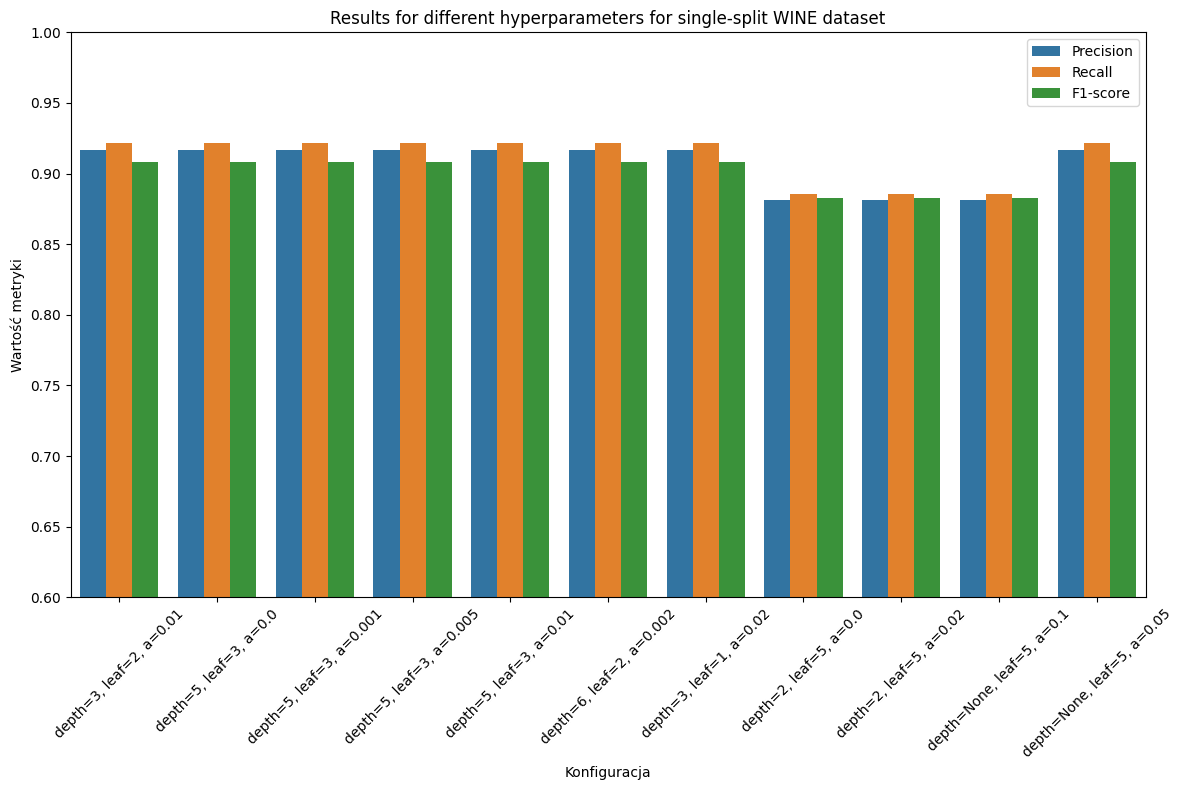

In [475]:
plot_results(wine_results, title="Results for different hyperparameters for single-split WINE dataset")

#### Najlepsze drzewo `f1=0.9079`
- Posiada głębokość równą 3 nie licząc korzenia
- Posiada zaledwie 4 liście
- Pierwszy atrybut `color_intensity` bardzo silnie rozgranicza `class_1` od pozostałych
- Jest minimalistyczne (krótkie) jednocześnie osiąga bardzo dobre wyniki, sugeruje to wysoką generalizacje modelu (nie będzie tu występował problem overfittingu)


#### "Statystyczne" Drzewo `f1=0.9079` - wyniki wyszły bardzo wysokie, jednocześnie takie same dla wielu drzew
- Mimo takiego samego wyniku jest większe od poprzedniego drzewa
- Ponownie atrybutem rozgraniczającym w korzeniu jest `color_intensity`
- Drzewo niepotrzebnie tworzy gałąź po lewej stronie zamiast liścia, próbując wyzbyć się pojedynczego przypadku `class_0`, spowodowane jest to warunkiem `min_leaf=3`
- Analizując dalsze przypadki drzewa, można zaobserowwać iż ustawienie `min_samples_leaf` powyżej 1 może tworzyć niepotrzebne rozgałęzienia


#### Najgorsze drzewo `f1=0.8828`
- Drzewo posiada głębokość równą 2 nie licząc korzenia, możliwe, iż jest zbyt płytkie by osiągnąć dobry wynik, zbyt generalizuje
- Posiada bardzo trudne warunki do spełnienia - niską głębokość i jednocześnie wymaga 5 rekordów w każnym liściu

Tree for depth=3, leaf=2, a=0.01 (max f1=0.9079)


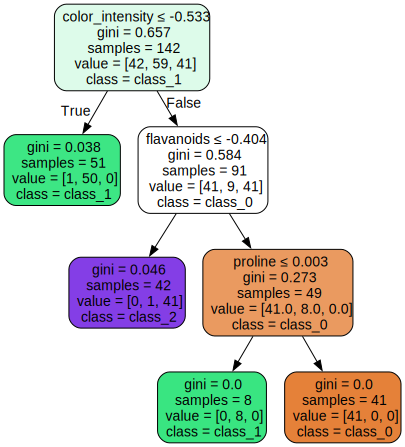

Tree for depth=5, leaf=3, a=0.0 (median f1=0.9079)


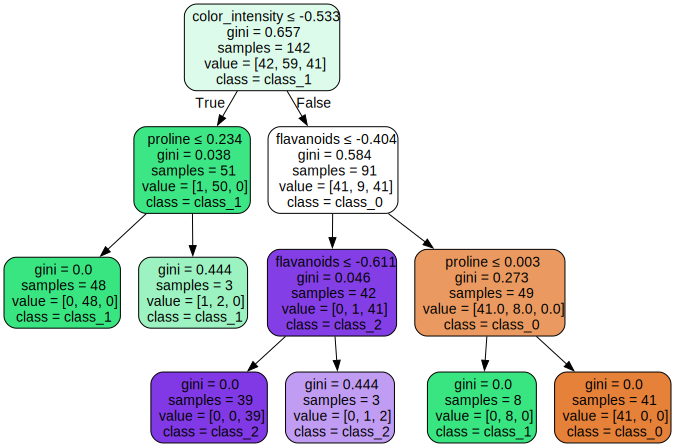

Tree for depth=2, leaf=5, a=0.0 (min f1=0.8828)


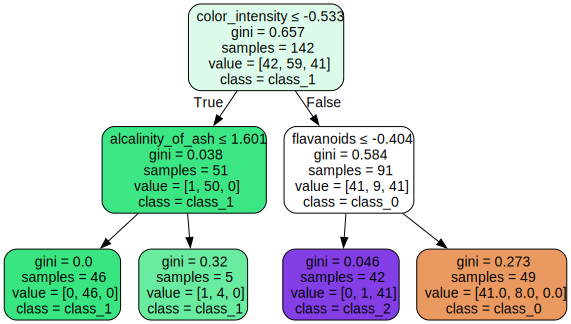

In [476]:
plot_trees(wine_results, X_wine.columns, wine.target_names)

### 5.2 PCB

- `Precision` dla większości modeli przy dobrze dobranych hiperparametrach osiąga bardzo wysokie wartości w okolicach 96%, co oznacza, że model rzadko błędnie klasyfikuje próbki klasy 0 jako 1.
- `Recall` jest znacznie niższy i w najlepszych przypadkach osiąga około 67%, co oznacza że niemal 33% próbek klasy 1 nie jest wykrywanych.
- `F1-score` balansujący precision i recall, przy najlepszych konfiguracjach osiąga 74%.
- Widać, że zbyt agresywna przycinka drzewa (`ccp_alpha=0.1`) lub zbyt głębokie drzewa bez regularyzacji (`depth=20, leaf=5, a=0.007`) prowadzą do znacznego spadku wszystkich metryk .

W przypadku mocno niezbalansowanego zbioru jak PCB, drzewo decyzyjne wykazuje wyraźną tendencję do wysokiej precyzji oraz niskiego recall.  
Najlepsze wyniki osiągają konfiguracje:
- `depth=10, leaf=3-6, a=0.001`
- `depth=25, leaf=5, a=0.001`
- `depth=None, leaf=3, a=0.001`


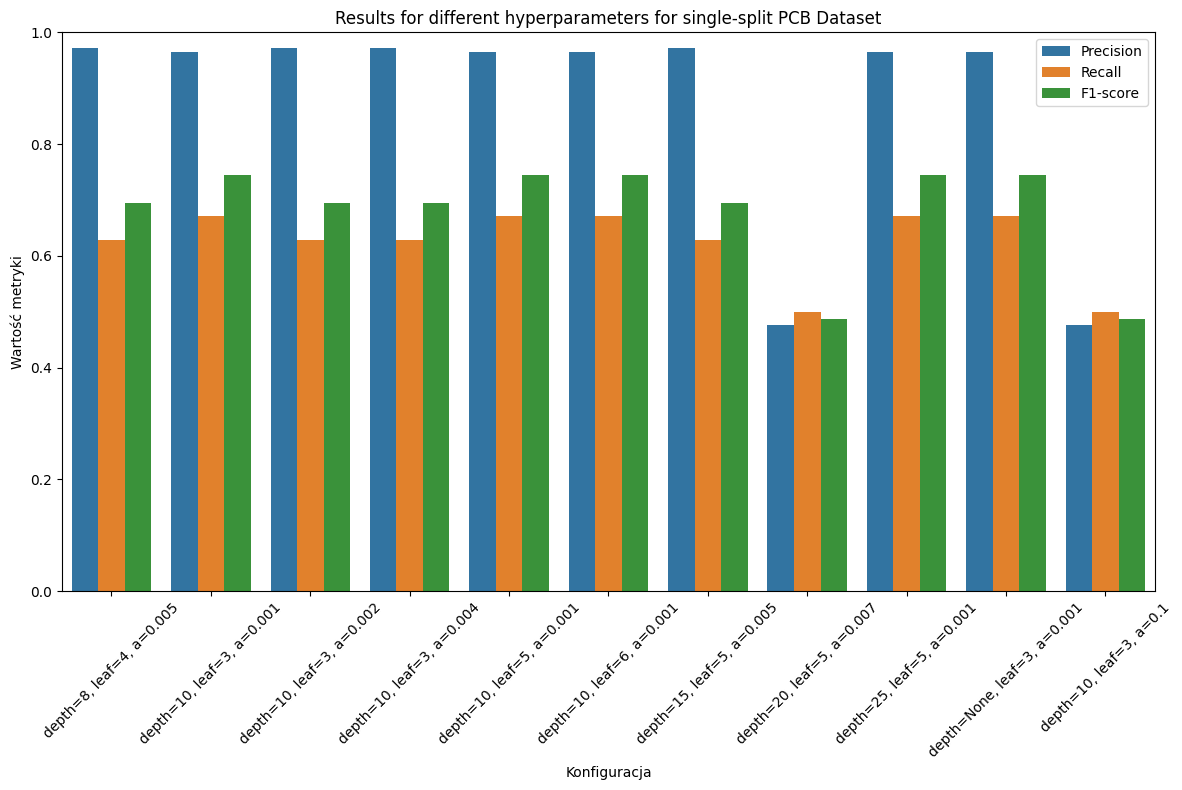

In [477]:
plot_results(pcb_results, title="Results for different hyperparameters for single-split PCB Dataset", min_value=0.0)

#### Najlepsze drzewo `f1=0.6864`
- Posiada głębokość równą 5 nie licząc korzenia
- Posiada zaledwie 8 liści
- Jest to znacznie głębsze drzewo od poprzednio analizowanych
- Posiada aż 3 liście, których zadaniem jest wykrycie `class_1`
- Drzewo jest silnie zgeneralizowane, nie posiada liści wskazujących bardzo intensywnie jedną klasę

#### "Statystyczne" Drzewo `f1=0.6673`
- Posiada głębokość równą 4 nie licząc korzenia
- Posiada zaledwie 5 liści
- Jest to bardzo analogiczne drzewo do powyższego, lecz posiada silniejszy wymóg pruningu
- Ze względu na silniejszą konieczność przycinania drzewa jest ono krótszą wersją drzewa powyższego

#### Najgorsze drzewo `f1=0.4877` (drzewo bardzo optymistyczne)
- Ze względu na bardzo silne wymagania pruningu, drzewo zostało ograniczone do jednego atrybutu, tym samym dla każdego rekordu optymistycznie określa, iż bankructwo nie wystąpi

Tree for depth=10, leaf=3, a=0.001 (max f1=0.6864)


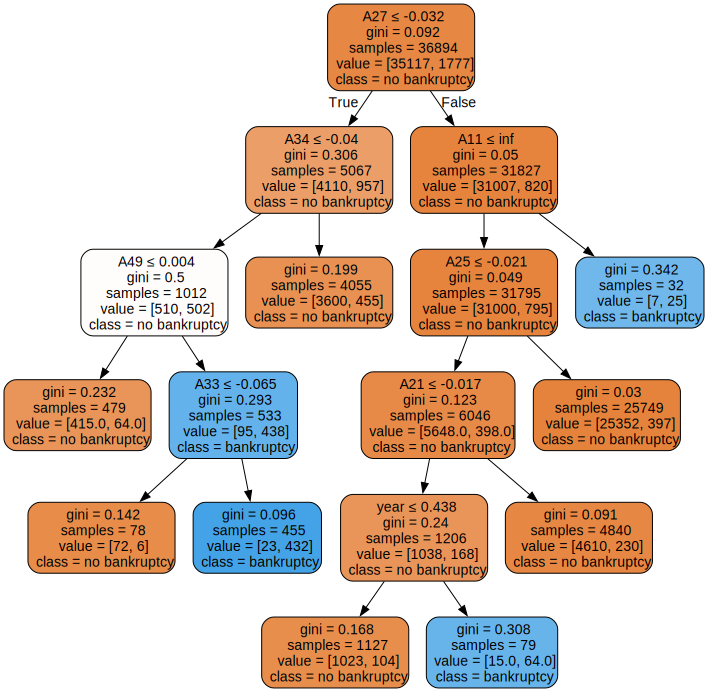

Tree for depth=10, leaf=3, a=0.002 (median f1=0.6673)


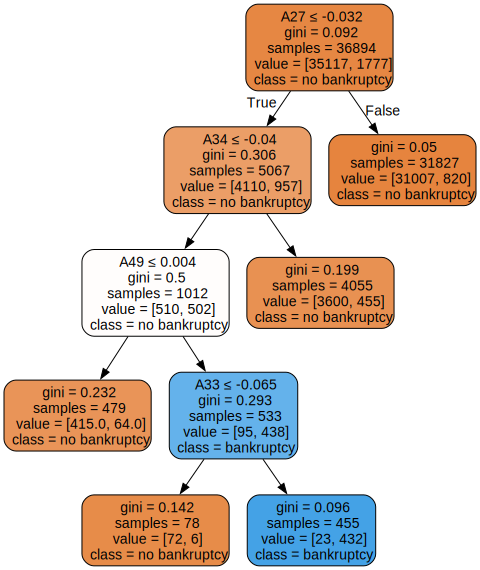

Tree for depth=20, leaf=5, a=0.007 (min f1=0.4876)


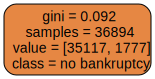

In [564]:
plot_trees(pcb_results, X_pcb.columns, ["no bankruptcy", "bankruptcy"])

## 6. K-fold Stratyfikacja vs brak stratyfikacji

Funkcja umożliwia wyuczenie klasyfikatora metodą Cross-Validation oraz zwraca `macro_avg` metryk

In [479]:
def train_and_evaluate_cv(X, y, params, title, target_names, mode="strat", cv_splits=5):
    scaler = StandardScaler()
    clf = DecisionTreeClassifier(**params)

    scores = []

    if mode == "strat":
        kf = StratifiedKFold(n_splits=cv_splits, shuffle=True)
    else:
        kf = KFold(n_splits=cv_splits, shuffle=True)

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        report = classification_report(
            y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0
        )['macro avg']

        scores.append(report)

    avg_scores = {
        metric: np.mean([score[metric] for score in scores])
        for metric in scores[0]
    }

    return title, clf, avg_scores

Funkcja rysuje wykres metryk `macro_avg` dla różnic między  Stratyfikacją a jej brakiem

In [480]:
def plot_metric_differences(results_strat, results_nonstrat, dataset):
    metrics = ['precision', 'recall', 'f1-score', 'support']
    titles = list(results_strat.keys())

    diffs = {metric: [] for metric in metrics}

    for title in titles:
        strat_metrics = results_strat[title][0]
        nonstrat_metrics = results_nonstrat[title][0]

        for metric in metrics:
            diff = strat_metrics[metric] - nonstrat_metrics[metric]
            diffs[metric].append(diff)

    x = np.arange(len(titles))
    width = 0.2

    _, ax = plt.subplots(figsize=(14, 6))
    
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, diffs[metric], width, label=metric)

    ax.set_ylabel('Stratified - Non-Stratified')
    ax.set_title(f'Difference in metrics for Stratified - Non-Stratified KFold in {dataset}')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(titles, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### 6.1 WINE

In [547]:
wine_results_strat = dict()

for config, title in zip(wine_configs, wine_titles):
    title, clf, macros = train_and_evaluate_cv(X_wine, y_wine, config, title, wine.target_names, mode="strat")
    wine_results_strat[title] = (macros, clf)

In [548]:
wine_results_nonstrat = dict()

for config, title in zip(wine_configs, wine_titles):
    title, clf, macros = train_and_evaluate_cv(X_wine, y_wine, config, title, wine.target_names, mode="nonstrat")
    wine_results_nonstrat[title] = (macros, clf)

- Wykonując kilukrotnie eksperyment stwierdzono, iż wyniki są mało stabilne - dla danych drzew stratyfikacja czasem pomaga, a czasem pogarsza wyniki.
- Mimo wszystko, poprawa wyników jest nieznaczna dla zbioru WINE, a jej natężenie jest zależne od huiperparametrów drzewa.
- Finalną decyzją jest stwierdzenie, iż Stratyfikacja dla zbioru WINE może nieznacznie pomóc dla statystycznego drzewa decyzyjnego.
- Z pewnością jej zaletą jest dopilnowanie równej reprezentacji klas w każdym foldzie, ustabilniając wyniki oraz powodując, iż są bardziej miarodajne

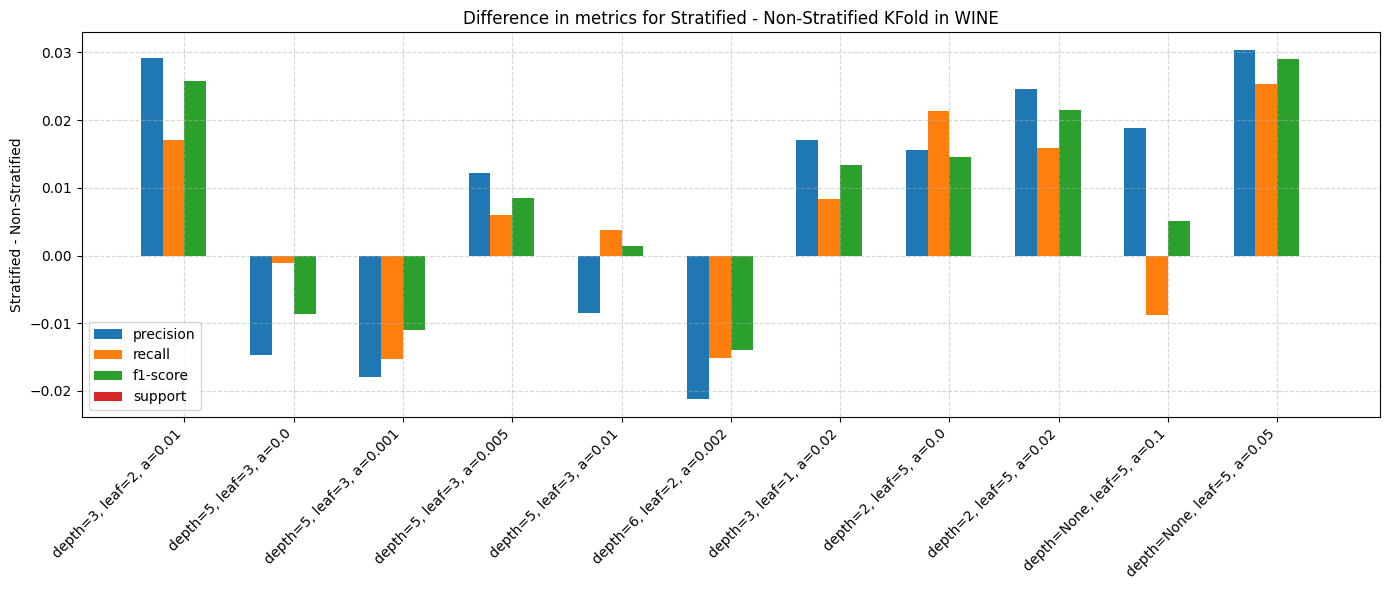

In [549]:
plot_metric_differences(wine_results_strat, wine_results_nonstrat, "WINE")

### 6.2 PCB

In [550]:
pcb_results_strat = dict()

for config, title in zip(pcb_configs, pcb_titles):
    title, clf, macros = train_and_evaluate_cv(X_pcb, y_pcb, config, title, ["bankrupcy", "non-bankrupcy"], mode="strat")
    pcb_results_strat[title] = (macros, clf)

In [551]:
pcb_results_nonstrat = dict()

for config, title in zip(pcb_configs, pcb_titles):
    title, clf, macros = train_and_evaluate_cv(X_pcb, y_pcb, config, title, ["bankrupcy", "non-bankrupcy"], mode="nonstrat")
    pcb_results_nonstrat[title] = (macros, clf)

- Analogicznie jak dla przykładu WINE, stratyfikacja nieznacznie poprawia lub pogarsza wyniki dla zbioru PCB.
- Nie występują charakterystyczne poprawy jednej z metryk, można więc stwierdzić, iż stratyfikacja nie ma dużego znaczenia dla wyików PCB
- Jednak należy wziąć pod uwagę, iż uniemożliwia ona przypadek braku reprezentacji jednej z klas w jednym z foldów.
- Stabilizuje wyniki. 

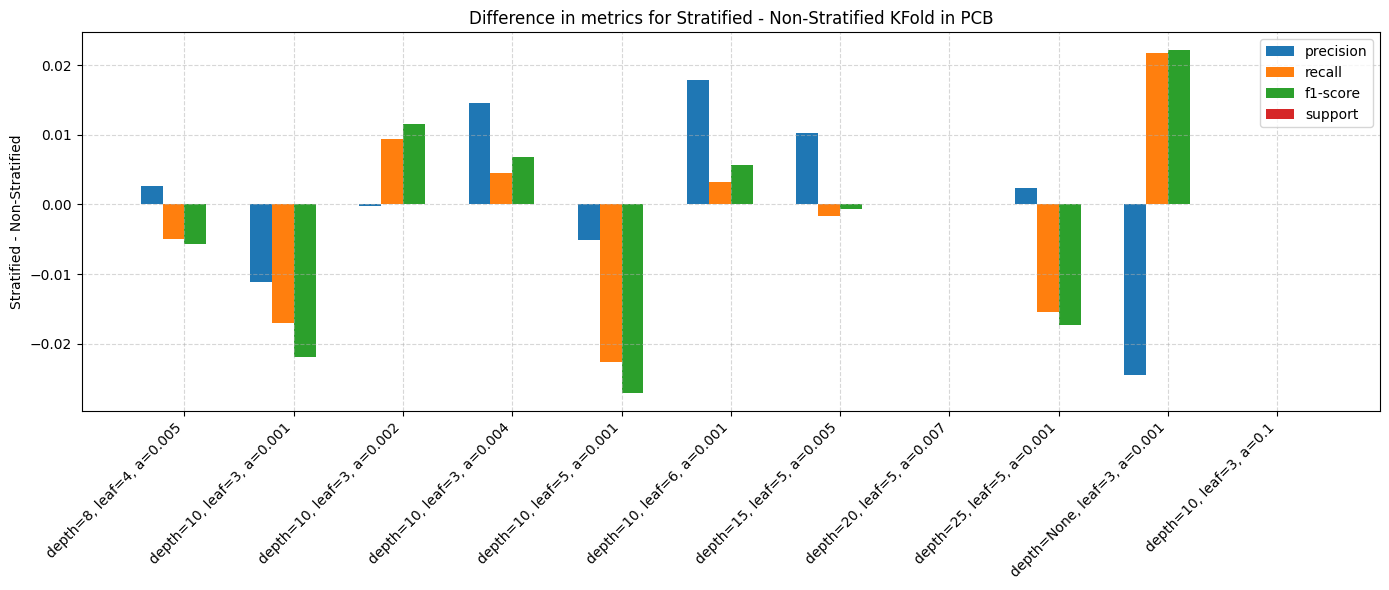

In [552]:
plot_metric_differences(pcb_results_strat, pcb_results_nonstrat, "PCB")

## 7. Parametryzacja class_weight

Funkcja obliczająca różnice między metrykami klas dla drzew balansowanych oraz niebalansowanych

In [553]:
def evaluate_class_weight_effect(X, y, configs, titles, target_names, mode="strat", cv_splits=5):
    results = {}

    for config, title in zip(configs, titles):
        config_base = config.copy()

        title_none = f"{title} (cw=None)"
        _, _, metrics_none = train_and_evaluate_cv(X, y, config_base, title_none, target_names, mode, cv_splits)

        config_bal = config.copy()
        config_bal['class_weight'] = 'balanced'
        title_bal = f"{title} (cw=balanced)"
        _, _, metrics_bal = train_and_evaluate_cv(X, y, config_bal, title_bal, target_names, mode, cv_splits)

        results[title] =  {metric: metrics_bal[metric] - metrics_none[metric] for metric in metrics_none}
        

    return results


Funkcja wizualizująca rónice między drzewami zbalansowanymi - niezbalansowanymi

In [554]:
def plot_weight_differences(differences, dataset):
    metrics = ['precision', 'recall', 'f1-score', 'support']
    titles = list(differences.keys())

    diffs = {metric: [] for metric in metrics}

    for title in titles:
        diff_metrics = differences[title]
        for metric in metrics:
            diffs[metric].append(diff_metrics[metric])
    

    x = np.arange(len(titles))
    width = 0.2

    _, ax = plt.subplots(figsize=(14, 6))
    
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, diffs[metric], width, label=metric)

    ax.set_ylabel('balanced - Normal')
    ax.set_title(f'Difference in metrics for balanced - normal KFold in {dataset}')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(titles, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### 7.1 WINE - W LIŚCIE NAPISANO, ŻEBY ZROBIĆ TYLKO DLA PCB, ALE Z CIEKAWOŚCI TESTUJE DLA WINE

In [555]:
wine_results = evaluate_class_weight_effect(
    X_wine, y_wine, wine_configs, wine_titles, wine.target_names, mode="strat"
)

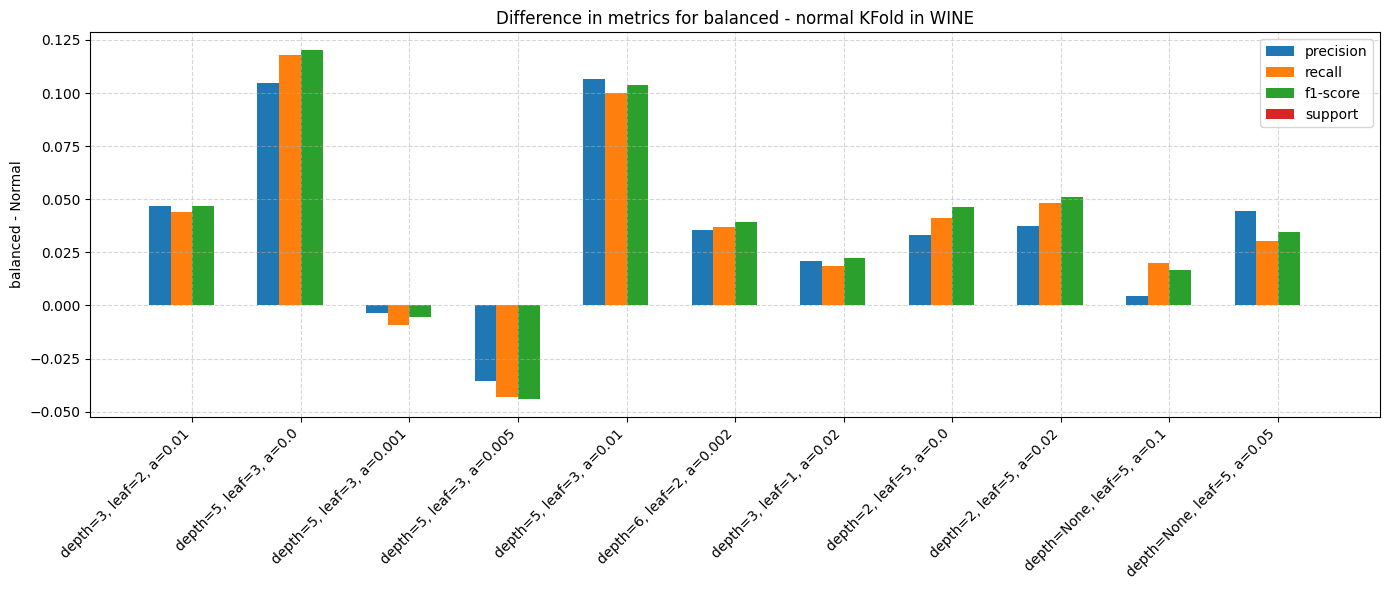

In [556]:
plot_weight_differences(wine_results, "WINE")

### 7.2 PCB

In [557]:
pcb_results = evaluate_class_weight_effect(
    X_pcb, y_pcb, pcb_configs, pcb_titles, ["bankrupcy", "non-bankrupcy"], mode="strat"
)

Zastosowanie class_weight posiada ogromny wpływ na wyniki klasyfikatora

- **Precision**: we wszystkich przypadkach spadło po zastosowaniu `balanced`, średnio o około 0.3. Wynika to ze zwiększenia liczby predykcji klasy mniejszościowej, co skutkuje większą liczbą false positives.
- **Recall**: zauważalny wzrost w każdej konfiguracji, od około +0.15 do +0.28, co potwierdza, że balanced skutecznie podnosi wykrywalność rzadkiej klasy.
- **F1-score**: zmiany umiarkowane, od niewielkich spadków do wzrostów, w zależności od balansu między precision a recall.

Zastosowanie balanced  poprawia recall klasy mniejszościowej w zbiorze PCB, kosztem spadku precision. Metoda sprawdzi się w scenariuszach, gdzie nadrzędnym celem jest wykrycie jak największej liczby przypadków defektów, nawet za cenę większej liczby fałszywych alarmów.


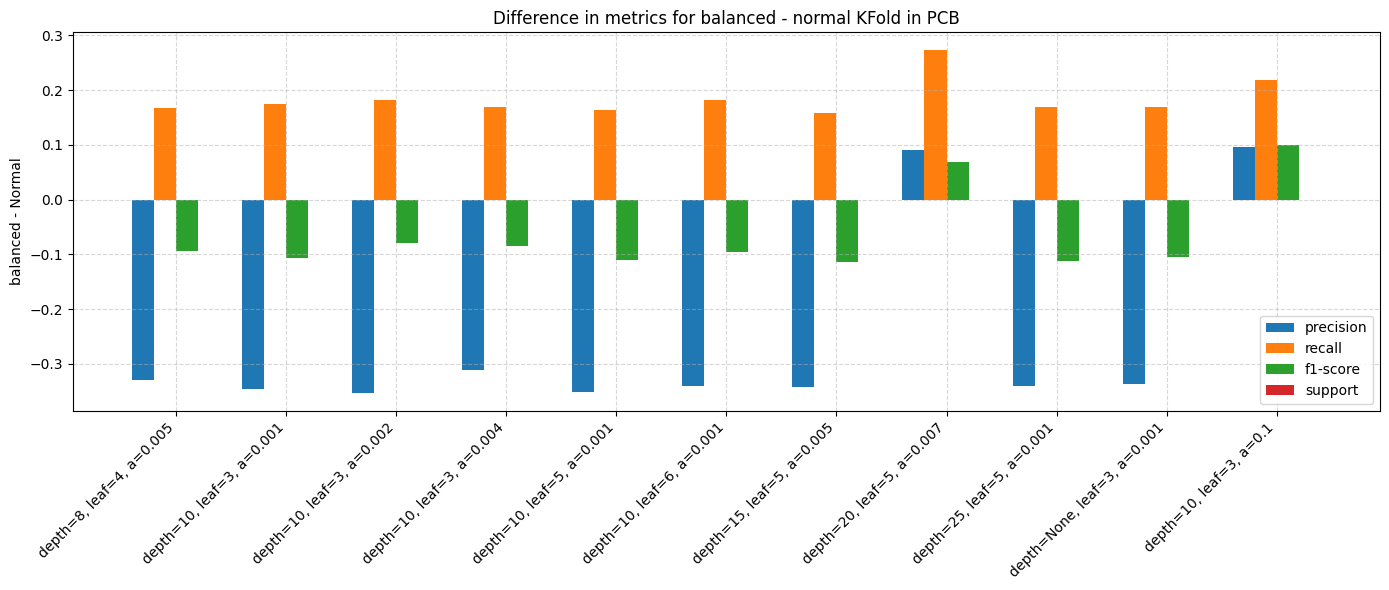

In [558]:
plot_weight_differences(pcb_results, "PCB")

## Obrazowanie customowego drzewa z zastosowanymi najlepszymi praktykami (stratyfikacja, balansowanie)

In [577]:
scaler = StandardScaler()
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, ccp_alpha=0.001, class_weight='balanced')

scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True)


for train_idx, test_idx in kf.split(X_pcb, y_pcb):
    X_train, X_test = X_pcb.iloc[train_idx], X_pcb.iloc[test_idx]
    y_train, y_test = y_pcb.iloc[train_idx], y_pcb.iloc[test_idx]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(
        y_test, y_pred, target_names=['no bankrupcy', 'bankrupcy'], output_dict=True, zero_division=0
    )['macro avg']

    scores.append(report)

avg_scores = {
    metric: np.mean([score[metric] for score in scores])
    for metric in scores[0]
}

In [578]:
avg_scores

{'precision': np.float64(0.5947052940264301),
 'recall': np.float64(0.8210099393178186),
 'f1-score': np.float64(0.6141121737990114),
 'support': np.float64(8681.0)}

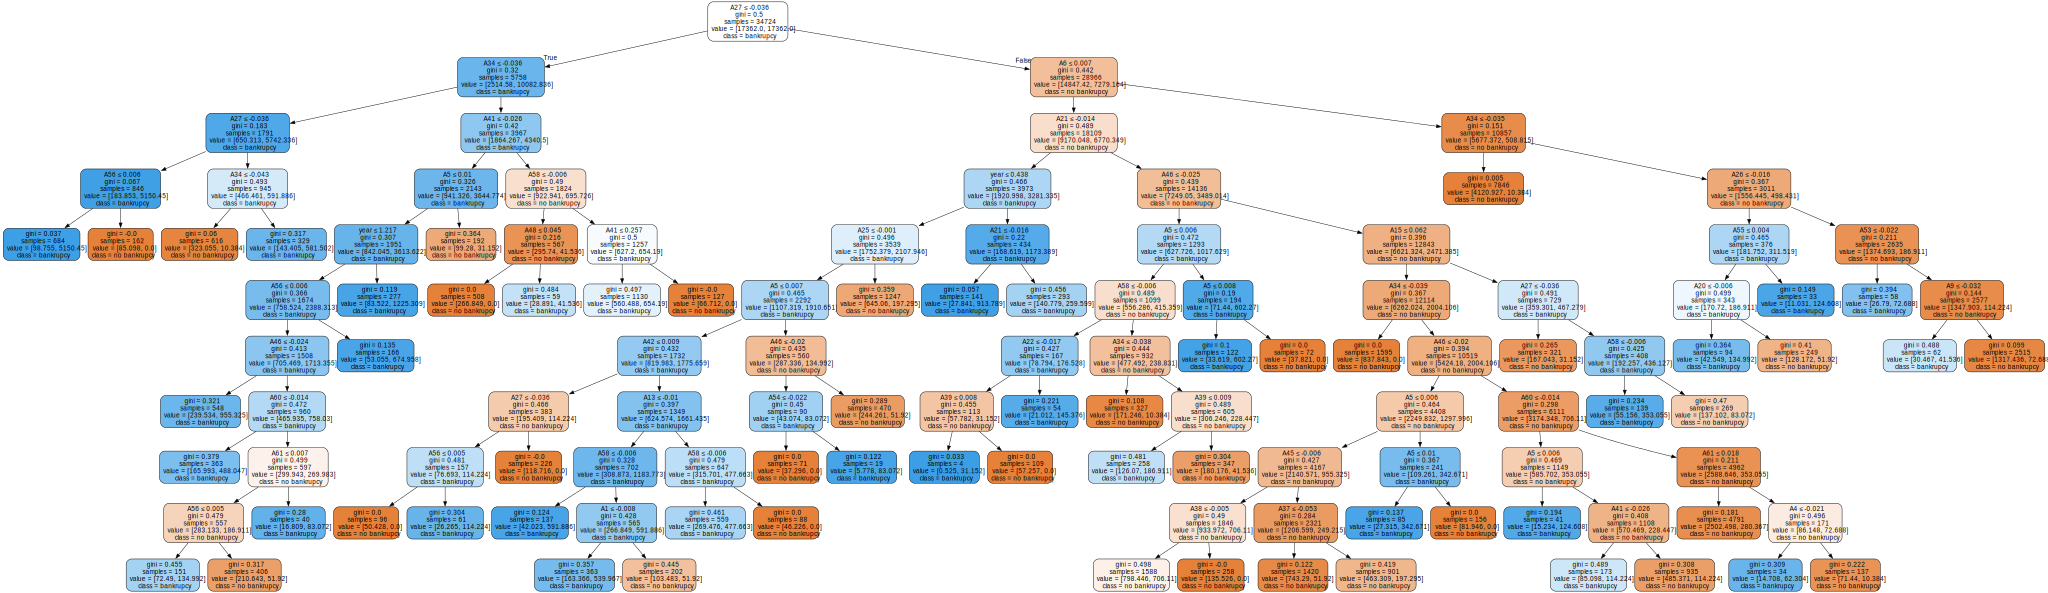

In [579]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=X_pcb.columns,
    class_names=["no bankrupcy", "bankrupcy"],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
display(graph)

## 8. Podsumowanie wyników

W przeprowadzonym laboratorium zbadano wpływ różnych hiperparametrów, stratyfikacji oraz cross-validacji na skuteczność klasyfikatorów drzewa decyzyjnego z wykorzystaniem współczynnika Giniego.
Analizie poddano dwa zbiory danych: **Wine** oraz **Polish Bankruptcy Companies (PCB)**.

- **Wpływ hiperparametrów:**
  - Ustalono, że zbyt głębokie drzewa prowadzą do przeuczenia modelu.
  - Dla obu zbiorów zauważono optymalne wartości głębokości, zapewniające kompromis między złożonością a skutecznością klasyfikacji.

- **Zastosowanie stratyfikacji w kroswalidacji:**
  - Stratyfikacja nie miała znaczącego wpływu na zbiór Wine oraz PCB, natomiast zapewniała bardziej stabilne i miarodajne wyniki poprzez zachowanie proporcji klas w każdym foldzie.

- **Parametr `class_weight`:**
  - Dla zbioru PCB zastosowanie `class_weight='balanced'` istotnie zwiększyło **recall** klasy mniejszościowej, co jest kluczowe w kontekście wykrywania potencjalnych bankructw.
  - Zauważono jednak spadek **precision**, co sugeruje kompromis między wykrywalnością a ilością fałszywych alarmów.
  - **F1-score** ulegał umiarkowanym zmianom, co jest bardzo logiczne, ponieważ manipulowaliśmy **precision** oraz **recall**.

- **Wizualizacje drzew:**
  - Stworzono przejrzyste wizualizacje drzew, które pomogły w interpretacji działania modeli oraz zidentyfikowaniu istotnych cech wpływających na decyzje klasyfikatora.

- **Najlepsze praktyki:**
  - Połączenie stratyfikacji i balansowania wag klas okazało się skuteczną metodą zwiększającą stabilność oraz trafność modelu – zwłaszcza w przypadku nierównomiernie rozłożonych klas.
  - Obydwie praktyki są kluczowe, jeżeli zależy na miarodajnych, stabilnych wynikach, gdzie obydwie klasy są bardzo znaczące mimo nierównomiernych reprezentacji.

### Wnioski końcowe:

- **Należy:**
  - Stosować stratified crossval, zwłaszcza dla nierównomiernych zbiorów danych.
  - Dostosować `class_weight` przy niezbalansowanych danych – zwiększa to recall, zmniejsza precision.
  - Eksperymentować z głębokością drzewa i liczbą cech, by znaleźć najlepszy kompromis między underfittingiem/generalizają a overfittingiem.

- **Nie należy:**
  - Polegać jedynie na accuracy – miary takie jak precision, recall i F1-score dostarczają pełniejszego obrazu skuteczności modelu.
  - Tak jak zostałem przekonany przez Dr. Perza, warto stosować `macro_avg` zamiast `weighted_avg` w celu precyzyjnego zbadania wpływu naszych decyzji na klasy mniej reprezentowane